<a href="https://colab.research.google.com/github/Pavel184/PyTorch_basic_course/blob/Homework_lesson_10/Homework_lesson_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework_lesson_10

In [1]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и их сохранение
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [2]:
import pandas as pd

In [3]:
import math
import matplotlib.pyplot as plt

In [4]:
#%%time

Создание датасета

In [5]:
def f(x):
  return (math.sin(x)/x - x/10)

In [6]:
x = np.arange(1,10000,1)/10000

In [7]:
f2 = np.vectorize(f)
y = f2(x)

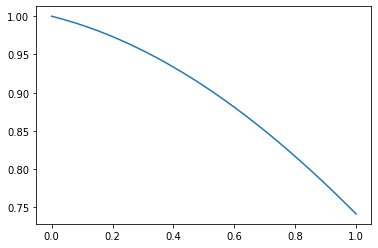

In [8]:
plt.plot(x, y)
plt.show()

In [9]:
z = np.stack((x,y),1)

In [10]:
df = pd.DataFrame(z,columns=['x', 'y'])
df.head(20)

,x,y
0,0.0001,0.999990
1,0.0002,0.999980
2,0.0003,0.999970
3,0.0004,0.999960
4,0.0005,0.999950
5,0.0006,0.999940
6,0.0007,0.999930
7,0.0008,0.999920
8,0.0009,0.999910
9,0.0010,0.999900


In [11]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, used_length):
      self.data = data.values.astype(np.float32)
      #self.y = y
      self.used_length = used_length
    
    def __len__(self):
        return len(self.data)-self.used_length

    def __getitem__(self,idx):
        length = self.used_length
        x = torch.tensor(self.data[idx:(idx+length)], dtype=torch.float64)
        return x

In [12]:
used_length = 1024 # длина последовательности
channels = 2 # 2 коордитаты x и y
batch_size = 10 # размер батча
seq_shape = (used_length, channels) # полная размерность последовательности

In [13]:
data = MyDataset(df,used_length)

In [14]:
train_loader = torch.utils.data.DataLoader(data,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=1,
                          drop_last=True)

Определим нужное нам устройство:

In [15]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [16]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Использование таких словарей позволяет нам варьировать параметры нашей сети в процессе использования
        self.activations = nn.ModuleDict([
                ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
                ['relu', nn.ReLU(0.2)]])
        
        def block(in_feat, out_feat, normalize=False, activation='lrelu'): #activation='relu
            layers = [nn.Linear(in_feat, out_feat)] # Если мы создаем последовательность слоев - то мы задаем их
                                                    # с помощью списка.
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(self.activations[activation]) # Эта сторчка означает тоже самое что и
                                                       # layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False), # Звездочка означает unpacking списка
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(seq_shape))),
            nn.Tanh()
        )
        # 2

    def forward(self, z):
        img = self.model(z)
        img = img.view(10, *seq_shape)
        return img


In [17]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) # Обьявляем веса как параметры слоя

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        # По формуле линейного слоя, нам нужно умножить наши данные на трнспонированные веса и добавить смещение
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(int(np.prod(seq_shape)), 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(128, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [19]:
n_epochs = 200 # количество эпох
lr = 0.0002 # шаг обучения 

b1 = 0.6 # гиперпараметр для оптимайзера Adam
b2 = 0.999 # гиперпараметр для оптимайзера Adam

latent_dim = 100 # Размерность случайного вектора, который подается на вход генератору


sample_interval = 25 # количество картинок для отображения процесса обучения

In [20]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [21]:
d_loss_history = []
g_loss_history = []

Процесс обучения:

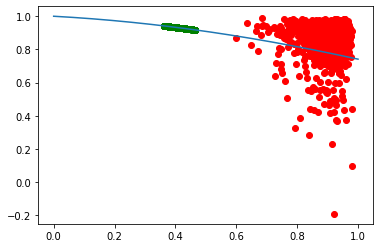

[Epoch 199/200] [Batch 872/8975] [D loss: 0.680600] [G loss: 0.708591]


<Figure size 432x288 with 0 Axes>

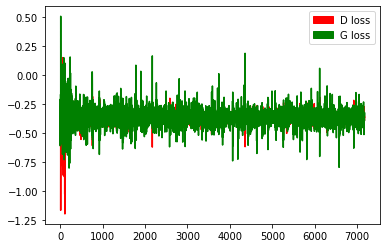

In [22]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')



for epoch in range(n_epochs):
    for i, (imgs) in enumerate(train_loader):
        #print(i, imgs.shape)
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)

        real_imgs = imgs.type(torch.FloatTensor).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        
        # Генерируем даные Генератором на основе шума
        gen_imgs = generator(z)
        
        # Подаем сгенерированые данные на Дискриминатор 
        validity = discriminator(gen_imgs)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(validity, valid)
        
        # Делаем шаг обучения нашего Генератора
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_imgs)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Опять делаем предсказание на Дискриминаторе с помощью сгенерированных данных
        fake_pred = discriminator(gen_imgs.detach())
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(train_loader) + i
    
        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)
                real = real_imgs.cpu().detach().numpy()
                x_real = real[0][:,:1]
                y_real = real[0][:,1:2]
                plt.scatter(x_real, y_real,c="g")


                gen = gen_imgs.cpu().detach().numpy()
                x_gen = gen[0][:,:1]
                y_gen = gen[0][:,1:2]
                plt.scatter(x_gen, y_gen,c="r")
                plt.plot(x, y)
                plt.show()
                print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(data), d_loss.item(), g_loss.item()) ) 


                display.display(plt.gcf())

                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()


                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
                plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
                plt.legend(handles=[red_patch, green_patch])
                plt.show()

            

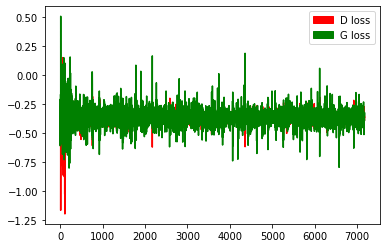

In [23]:
plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
plt.legend(handles=[red_patch, green_patch])
plt.show()

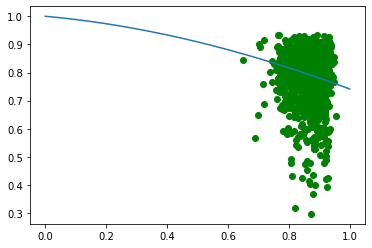

In [24]:
gen_imgs = generator(z).cpu()
gen = gen_imgs.detach().numpy()
x_gen = gen[0][:,:1]
y_gen = gen[0][:,1:2]
plt.scatter(x_gen, y_gen,c="g")
plt.plot(x, y)
plt.show()